### This program outlines a series of steps taken for producing a predicted concentration value from the proto2 sensor

## First step is to load in all of our necessary modules. 
### Pandas and numpy do most of the heavy lifting in this script. Matplotlib is mainly for plotting

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from datetime import datetime, timedelta, date
from matplotlib.path import Path
import matplotlib.patheffects as pe
import glob,os
import time
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sys


import warnings
warnings.filterwarnings("ignore")

In [2]:
#get the corrected proto2 filenames

#path_corrected_proto2='/data/aq/inhouse/corrected/csv/'
#path_corrected_proto2='corrected-Sept-Modified/'
path_corrected_proto2='despiked_proto2/'

proto2_corrected_filepaths=[]
for file in sorted(os.listdir(path_corrected_proto2)):
    if file != '.ipynb_checkpoints':
        proto2_corrected_filepaths.append(path_corrected_proto2+file)
    
proto2_corrected_from_files=(pd.read_csv(f,on_bad_lines='skip') for f in proto2_corrected_filepaths)
proto2_corrected=pd.concat(proto2_corrected_from_files)

times=pd.to_datetime(proto2_corrected['Unnamed: 0'],format='%Y-%m-%d %H:%M:%S')
proto2_corrected=proto2_corrected.set_index(times)
proto2_corrected.index.names=['date']
proto2_corrected=proto2_corrected.drop('Unnamed: 0',1)
proto2_corrected;

### Resampling the high frequency proto2 data into hour averages so that it's compatible with hourly observations

In [3]:
#take high frequency proto2 data and resample to hourly mean
houravg=proto2_corrected.drop(columns=['datetimestamp']).apply(pd.to_numeric).resample('60min').mean()

### Pulling in observed gas concentrations from DEC. This was acquired using the EPA API

In [4]:
#get the epa filenames

path_epa='/data/aq/DEC/csv/'

epa_filepaths=[]
for file in sorted(os.listdir(path_epa)):
    epa_filepaths.append(path_epa+file)

In [5]:
epa_from_files=(pd.read_csv(f) for f in epa_filepaths)
epa_df=pd.concat(epa_from_files)
epa_df=epa_df.set_index(pd.to_datetime(epa_df['date']))

### Define some dictionaries that tie the concentration number code to its appropriate name

In [6]:
#set dictionary that matches varid to field name
proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}
epa_table={42101:'Trace CO (ppb)',44201:'O3 (ppb)',42601:'NOx (ppb)',42602:'NO2 (ppb)',88101:'PM25FEM (ug/m3)'}

### Toss out times in the DEC observations where there is no recorded data in proto2

In [7]:
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]
epa_df_matching_proto2;

### Now prepare the input data and perform the regression

In [8]:
# Select date ranges corresponding to months 
july = (epa_df_matching_proto2['date'] >= '2021-07-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-07-31 23:00:00') 
august = (epa_df_matching_proto2['date'] >= '2021-08-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-08-31 23:00:00') 
september = (epa_df_matching_proto2['date'] >= '2021-09-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-09-31 23:00:00') 
october = (epa_df_matching_proto2['date'] >= '2021-10-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-10-31 23:00:00') 
november = (epa_df_matching_proto2['date'] >= '2021-11-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-11-31 23:00:00') 

## Apply Regression

### Generate regression coefficients script 

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
from scipy import stats
import statistics

import warnings
warnings.filterwarnings("ignore")

def generate_coefficients(training_predictors, training_reference_concentrations, method):
    '''
    INPUT...
    training_predictors = list of dataframe corresponding of predictors in training period 
    training_reference_concentrations = dataframe containing reference concentrations (DEC) during training period
    
    method = 'linear' or 'quadratic' (only LINEAR works as of 02/08/2023)    
    ===========================================================
    RETURNS...
    00 = coefficient + y-intercepts of regression equation as a dictionary (this is what's important!)
    01 = model (kept for documentation purposes)
    '''
    
    training_predictor_fields=pd.concat(training_predictors,axis=1)    
    training_sensor_field=training_reference_concentrations
    
    if method == 'linear':
        # apply regression
        reg = LinearRegression()
        model = reg.fit(training_predictor_fields.values, training_sensor_field.values)
        
        # coefficient dictionary
        coefs=model.coef_
        coef_dict={}
        for num_of_coefs in range(len(model.coef_)):
            coef_dict[str(num_of_coefs).zfill(2)]=coefs[num_of_coefs]
        coef_dict['intercept']=model.intercept_
    
    # QUADRATIC IS UNFINISHED 
    if method == 'quadratic':
        # apply regression
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly_features = poly.fit_transform(training_predictor_fields.reshape(-1,10))
        poly_reg_model = LinearRegression()

        model = poly_reg_model.fit(training_predictor_fields.values, training_sensor_field.values)
        
        # coefficient dictionary
        coefs=reg.coef_
        coef_dict={}
        for num_of_coefs in range(len(reg.coef_)):
            coef_dict[str(num_of_coefs).zfill(2)]=coefs[num_of_coefs]
        coef_dict['intercept']=reg.intercept_


    return coef_dict,model

### Calibrate script

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

import statsmodels.api as sm
from scipy import stats
import statistics

import warnings
warnings.filterwarnings("ignore")

# remove testing_reference_concentrations

def calibrate(model,testing_predictors):
    '''
    INPUT...
    coef_dict = coefficient dictionary returned from generate_coefficients function
    testing_predictors = list of dataframe corresponding of predictors in testing period 
    testing_reference_concentrations = dataframe containing reference concentrations (DEC) during testing period
        
    ===========================================================
    RETURNS...
    00 = calibrated data as an array 
    01 = performance metrics aka stats 
          --> r-squared 
          --> m and slope from fitting the reference data (x) against the calibrated data (y)
          --> RMSE using sklearn module
          --> z-score mean and array 
          --> still need to add: % bias, t-test, and p-value 
    '''
    
    intercept = model[0]['intercept'] 
    del model[0]['intercept']
    
    #print('\nIntercept = ', intercept)

    calibrated_data = intercept 

    for coefficients in range(len(model[0])):
        if coefficients < 10: 
            coefficient = model[0]['0'+str(coefficients)] # access each coefficient
        else:        
            coefficient = model[0][str(coefficients)] # access each coefficient
    
        #print('Calibrating w/ coefficient = ',testing_predictors[coefficients].name)
        #print('  ... value of coefficient = ',coefficient)
            
        calibrated_data += coefficient*testing_predictors[coefficients] # recursive function
    
    model[0]['intercept'] = intercept

    # generate statisitics 
    n=len(testing_reference_concentrations)
    r2=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
    
    m = np.polyfit(testing_reference_concentrations,calibrated_data,1) 
    z_score_array = np.array((calibrated_data-calibrated_data.mean())/statistics.stdev(calibrated_data))
            
    stats_dict={} 
    stats_dict['r2'] = r2_score(testing_reference_concentrations,calibrated_data)
    stats_dict['m'] = m[0]
    stats_dict['m_y-int'] = m[1]
    stats_dict['RMSE'] = sqrt(mean_squared_error(calibrated_data, testing_reference_concentrations)) 
    stats_dict['z-score_mean'] = z_score_array.mean()
    stats_dict['z-score_array'] = z_score_array
    stats_dict['r2_hardcoded'] = r2
    stats_dict['percent_bias'] = ((testing_reference_concentrations.mean()-calibrated_data.mean())/(abs(testing_reference_concentrations.mean())))*100

    return calibrated_data,stats_dict

Generating coefficients for  CO ...
Calibrating for  CO ...
Plotting for  CO ...


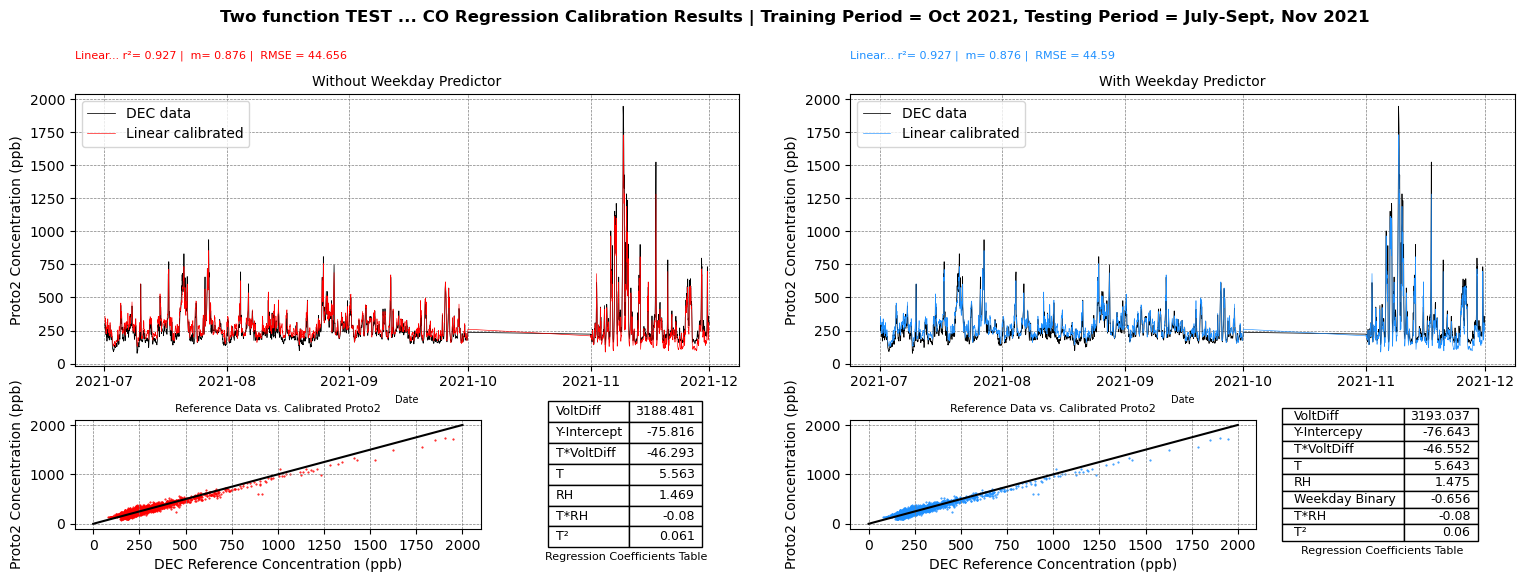



Generating coefficients for  O3 ...
Calibrating for  O3 ...
Plotting for  O3 ...


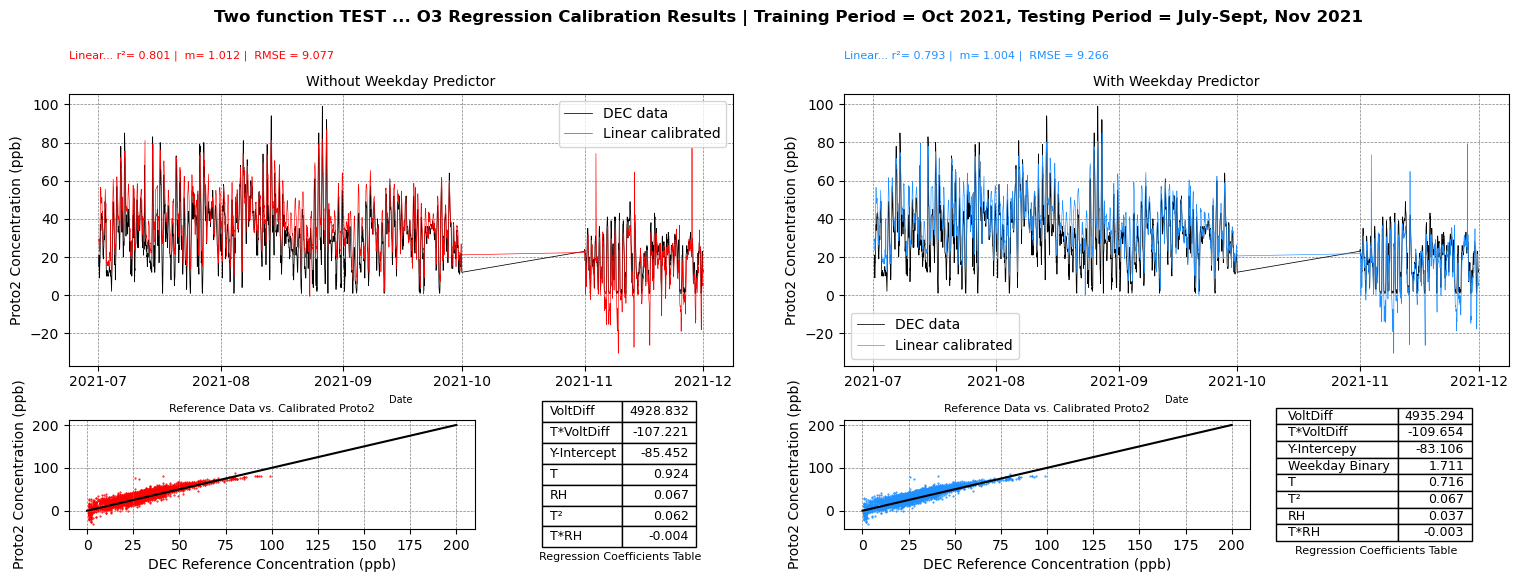



Generating coefficients for  NO ...
Calibrating for  NO ...
Plotting for  NO ...


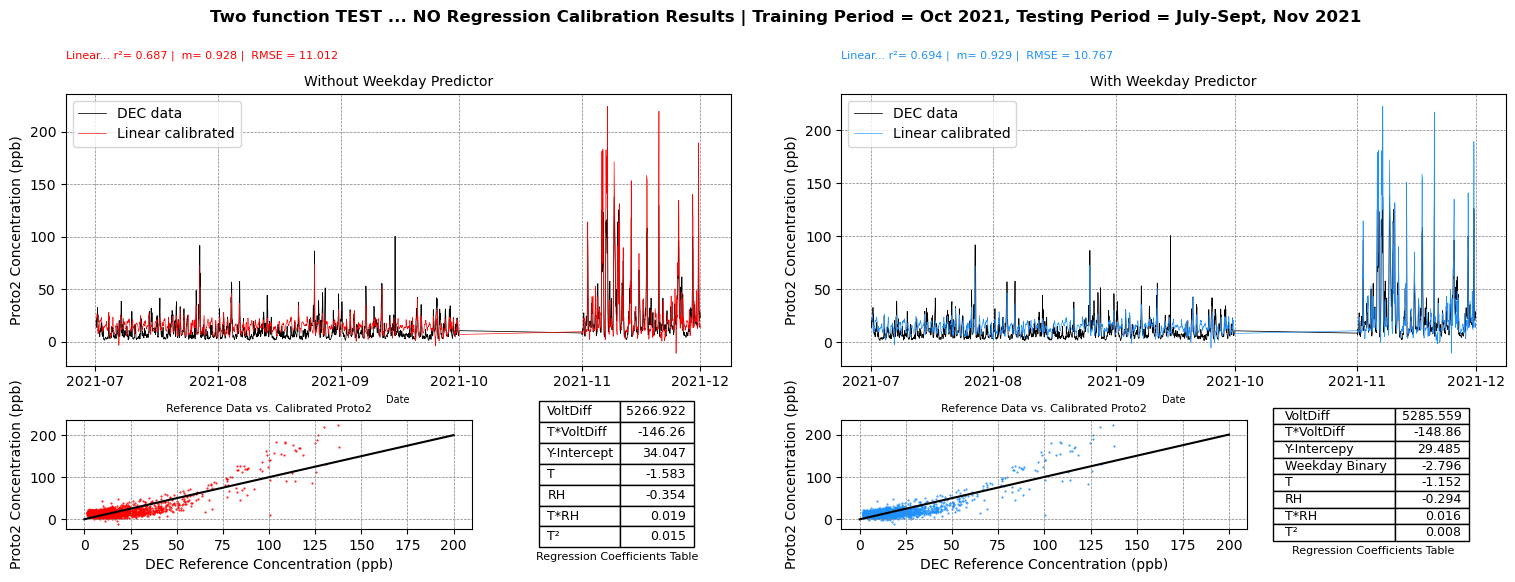



Generating coefficients for  NO2 ...
Calibrating for  NO2 ...
Plotting for  NO2 ...


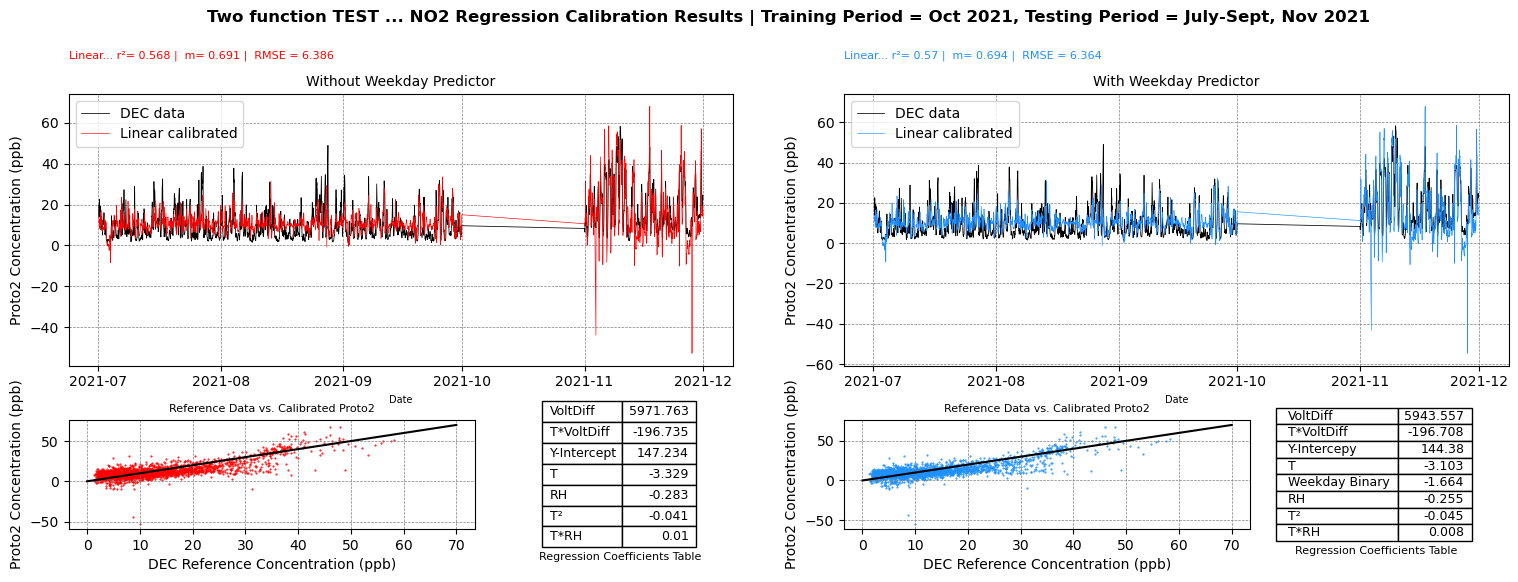



Generating coefficients for  pm25 ...
Calibrating for  pm25 ...
Plotting for  pm25 ...


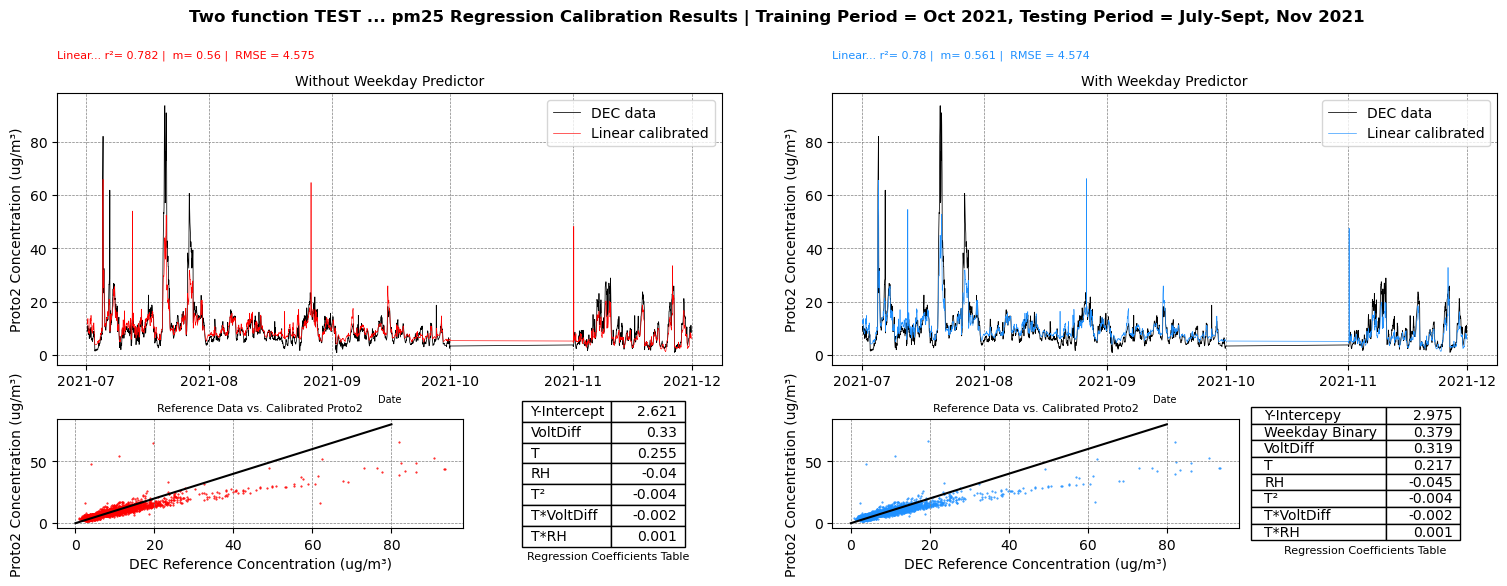

In [14]:
#the observed concentrations and proto2 data are using different timezones. apply a 5 hour fix to shift them over
#long term it may be wise to just correct proto2 data and rewrite it as a file
tshift=5

#specify the method you want for the regression
method='linear'

#define an empty dictionary to hold output
vd={}
model_directory = {}

# CO:42101  O3NO2:44201  NO:42601  NO2:42602 PM2.5:88101
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42101]:


    #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    if var_id==44201:
        epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
        epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)

    else:
        epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
        epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)


    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,houravg],axis=1).dropna()

    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'

    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'

    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]

        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'


    # perform some additional last minute qc on the data
    # this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
    combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                         & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                         & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
    # some fun time predictors 
    combined_df_filtered['decimal_day'] = combined_df_filtered.index.dayofyear # create a column for decimal day; aka time predictor 
    
    combined_df_filtered['dayofweek'] = combined_df_filtered.index.dayofweek # creates column of weekday numbers 
    combined_df_filtered.loc[combined_df_filtered['dayofweek'] <= 4, 'weekday_binary'] = 0 # converts weekdays to 0 (if Zamora, now 1) 
    combined_df_filtered.loc[combined_df_filtered['dayofweek'] > 4, 'weekday_binary'] = 1 # converts weekends to 1 (if Zamora, now 0) 
    
    daylight_mask = (combined_df_filtered.index >= '06:00:00') & (combined_df_filtered.index  <= '23:00:00') # delinate daytime
    combined_df_filtered.loc[daylight_mask, 'daylight_hours_binary'] = 1 # converts daytime to 1
    combined_df_filtered['daylight_hours_binary'] = combined_df_filtered['daylight_hours_binary'].fillna(0) # nighttime is 0
    
    # delineate training and test periods 
    combined_df_filtered_training=combined_df_filtered.loc[october]
    combined_df_filtered_testing=combined_df_filtered.loc[july+august+september+november]
                      
    # training fields using proto2_QC.csv 
    training_reference_concentrations = combined_df_filtered_training['value']
    
    training_data_A = [combined_df_filtered_training['temp_sht31_degC'], # T
                     combined_df_filtered_training['temp_sht31_degC']**2, # T^2
                     combined_df_filtered_training['rh_sht31_percent'], # RH
                     combined_df_filtered_training['temp_sht31_degC']*combined_df_filtered_training['rh_sht31_percent'], # T-RH interaction
                     combined_df_filtered_training['temp_sht31_degC']*combined_df_filtered_training[gname+'_voltdiff'], # T-sensor interaction
                     combined_df_filtered_training[gname+'_voltdiff']] # sensor
                     #combined_df_filtered_training['weekday_binary']]  # binary weekend
                     #combined_df_filtered_training['decimal_day']] # decimal day
            
    training_data_A_predictors = {"00": "T", '01':'T²', '02':'RH','03':'T*RH','04':'T*VoltDiff',
                    '05':'VoltDiff','intercept':'Y-Intercept'}
            
    training_data_B = [combined_df_filtered_training['temp_sht31_degC'], # T
                     combined_df_filtered_training['temp_sht31_degC']**2, # T^2
                     combined_df_filtered_training['rh_sht31_percent'], # RH
                     combined_df_filtered_training['temp_sht31_degC']*combined_df_filtered_training['rh_sht31_percent'], # T-RH interaction
                     combined_df_filtered_training['temp_sht31_degC']*combined_df_filtered_training[gname+'_voltdiff'], # T-sensor interaction
                     combined_df_filtered_training[gname+'_voltdiff'], # sensor
                     combined_df_filtered_training['weekday_binary']]  # binary weekend
                     #combined_df_filtered_training['decimal_day']] # decimal day
    
    training_data_B_predictors = {"00": "T", '01':'T²', '02':'RH','03':'T*RH','04':'T*VoltDiff',
                    '05':'VoltDiff','06':'Weekday Binary','intercept':'Y-Intercepy'}
                                  
    # testing fields using proto2_QC.csv 
    testing_reference_concentrations = combined_df_filtered_testing['value']
    
    testing_data_A = [combined_df_filtered_testing['temp_sht31_degC'], # T
                    combined_df_filtered_testing['temp_sht31_degC']**2, # T^2
                    combined_df_filtered_testing['rh_sht31_percent'], # RH
                    combined_df_filtered_testing['temp_sht31_degC']*combined_df_filtered_testing['rh_sht31_percent'], # T-RH interaction
                    combined_df_filtered_testing['temp_sht31_degC']*combined_df_filtered_testing[gname+'_voltdiff'], # T-sensor interaction
                    combined_df_filtered_testing[gname+'_voltdiff']]  # sensor
                    #combined_df_filtered_testing['weekday_binary']] # binary weekend
                    #combined_df_filtered_testing['decimal_day']] # decimal day
            
    testing_data_B = [combined_df_filtered_testing['temp_sht31_degC'], # T
                    combined_df_filtered_testing['temp_sht31_degC']**2, # T^2
                    combined_df_filtered_testing['rh_sht31_percent'], # RH
                    combined_df_filtered_testing['temp_sht31_degC']*combined_df_filtered_testing['rh_sht31_percent'], # T-RH interaction
                    combined_df_filtered_testing['temp_sht31_degC']*combined_df_filtered_testing[gname+'_voltdiff'], # T-sensor interaction
                    combined_df_filtered_testing[gname+'_voltdiff'],  # sensor
                    combined_df_filtered_testing['weekday_binary']] # binary weekend
                    #combined_df_filtered_testing['decimal_day']] # decimal day
    

    print('Generating coefficients for ', gname,'...')
    model_A = generate_coefficients(training_data_A,training_reference_concentrations, method='linear')
    model_B = generate_coefficients(training_data_B,training_reference_concentrations, method='linear')

    print('Calibrating for ', gname,'...')
    calibrate_A = calibrate(model_A,testing_data_A)
    calibrate_B = calibrate(model_B,testing_data_B)

    model_perf_A = calibrate_A[1]
    model_perf_B = calibrate_B[1]

    calibrated_data_A = calibrate_A[0]
    calibrated_data_B = calibrate_B[0]

    testing_period = testing_reference_concentrations.index
        
    ''' PLOT TIME :) '''
    print('Plotting for ',gname,'...')
    
    rows = 6
    columns = 6
    fig = plt.subplots(figsize=(16,12))
    plt.suptitle('Two function TEST ... '+gname+' Regression Calibration Results | Training Period = Oct 2021, Testing Period = July-Sept, Nov 2021', 
                 x=0.45,y=0.95,fontsize=12,fontweight ="bold")

    #predictionA_table = plt.subplot2grid((rows, columns), (2, 2))
    #predictionB_table = plt.subplot2grid((rows, columns), (2, 5))
    plt.subplots_adjust(left=0, wspace=0.75, hspace=0.50)

    ''' A - DEC vs. Calibrated time series plot (left) '''
    predictionA_timeseries = plt.subplot2grid((rows, columns), (0, 0), rowspan=2, colspan=3)
    #predictionA_timeseries.set_title('time_series_A')
    predictionA_timeseries.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    predictionA_timeseries.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.55)
    predictionA_timeseries.plot(testing_period,calibrated_data_A,label='Linear calibrated', color='red',linewidth=0.45)
    predictionA_timeseries.legend()  
    predictionA_timeseries.set_title('Without Weekday Predictor', fontsize=10)
    predictionA_timeseries.set_xlabel('Date',fontsize=7)
    predictionA_timeseries.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')

    ''' B - DEC vs. Calibrated time series plot (right) '''
    predictionB_timeseries = plt.subplot2grid((rows, columns), (0, 3), rowspan=2, colspan=3)
    #predictionB_timeseries.set_title('time_series_B')
    predictionB_timeseries.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    predictionB_timeseries.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.55)
    predictionB_timeseries.plot(testing_period,calibrated_data_B,label='Linear calibrated', color='dodgerblue',linewidth=0.45)
    predictionB_timeseries.legend()  
    predictionB_timeseries.set_title('With Weekday Predictor', fontsize=10)
    predictionB_timeseries.set_xlabel('Date',fontsize=7)
    predictionB_timeseries.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    
    '''A - DEC vs. Calibrated trend  plot (left bottom left) '''
    predictionA_dataseries = plt.subplot2grid((rows, columns), (2, 0), rowspan=1, colspan=2)
    #predictionA_dataseries.set_title('data_series_A')
    predictionA_dataseries.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    # 1:1 line
    if var_id==42101: # CO
        xmax = 2000
    if var_id==44201: # O3
        xmax = 200
    if var_id==42601: # NO
        xmax = 200
    if var_id==42602: # N02
        xmax = 70
    if var_id==88101: # pm25
        xmax = 80 
    ymax=xmax
    point1 = [0,0]
    point2 = [xmax,ymax]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    predictionA_dataseries.plot(x_values, y_values, color='black', label='1:1 Line')
    # plotting data... 
    predictionA_dataseries.scatter(testing_reference_concentrations,calibrated_data_A,color='red',s=0.25)
    predictionA_dataseries.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
    predictionA_dataseries.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    predictionA_dataseries.set_title('Reference Data vs. Calibrated Proto2', fontsize=8)
    
    '''B - DEC vs. Calibrated trend  plot (right bottom left) '''
    predictionB_dataseries = plt.subplot2grid((rows, columns), (2, 3), rowspan=1, colspan=2)
    #predictionB_dataseries.set_title('data_series_A')
    predictionB_dataseries.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

    predictionB_dataseries.plot(x_values, y_values, color='black', label='1:1 Line')
    # plotting data... 
    predictionB_dataseries.scatter(testing_reference_concentrations,calibrated_data_B,color='dodgerblue',s=0.25)
    predictionB_dataseries.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
    predictionB_dataseries.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    predictionB_dataseries.set_title('Reference Data vs. Calibrated Proto2', fontsize=8)
    
    ''' Regression Coefficient Table (bottom right) '''
    # create dataframe of table data 
    prediction_A_table = plt.subplot2grid((rows, columns), (2, 2))
    prediction_A_table_data = pd.DataFrame()
    prediction_A_table_data = prediction_A_table_data.append(model_A[0],ignore_index=True)
    prediction_A_table_data = prediction_A_table_data.transpose()
    prediction_A_table_data = prediction_A_table_data.rename(columns = {0:'Coefficient'}, index=training_data_A_predictors)
    prediction_A_table_data = prediction_A_table_data.reindex((prediction_A_table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
    prediction_A_table_data = prediction_A_table_data.round(3) # rounding coefficients to 3 decimal places 
    
    prediction_A_table.text(-0.09,-0.087,'Regression Coefficients Table', fontsize=8)

    #prediction_A_table.text(-0.11,-0.09,'Regression Coefficients Table')
    #hide the axes
    prediction_A_table.patch.set_visible(False)
    prediction_A_table.axis('off')
    prediction_A_table.axis('tight')
    regression_table_A = prediction_A_table.table(cellText=prediction_A_table_data.values, rowLabels=prediction_A_table_data.index, loc='center')
    regression_table_A.scale(0.5,1.25)
    regression_table_A.set_fontsize(10)
    
    ''' Regression Coefficient Table (bottom right) '''
    # create dataframe of table data 
    prediction_B_table = plt.subplot2grid((rows, columns), (2, 5))
    prediction_B_table_data = pd.DataFrame()
    prediction_B_table_data = prediction_B_table_data.append(model_B[0],ignore_index=True)
    prediction_B_table_data = prediction_B_table_data.transpose()
    prediction_B_table_data = prediction_B_table_data.rename(columns = {0:'Coefficient'}, index=training_data_B_predictors)
    prediction_B_table_data = prediction_B_table_data.reindex((prediction_B_table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
    prediction_B_table_data = prediction_B_table_data.round(3) # rounding coefficients to 3 decimal places 

    prediction_B_table.text(-0.104,-0.08,'Regression Coefficients Table', fontsize=8)
    #hide the axes
    prediction_B_table.patch.set_visible(False)
    prediction_B_table.axis('off')
    prediction_B_table.axis('tight')
    regression_table_B = prediction_B_table.table(cellText=prediction_B_table_data.values, rowLabels=prediction_B_table_data.index, loc='center')
    regression_table_B.scale(0.5,1.0)
    regression_table_B.set_fontsize(10)
    
    ''' Display model performance statistics (text) '''
    decimals = 3
    predictionA_timeseries.text(0,1.13, 'Linear... r²= '+str(round(model_perf_A['r2_hardcoded'],decimals))+' |  m= '+str(round(model_perf_A['m'],decimals))+' |  RMSE = '+str(round(model_perf_A['RMSE'],decimals)),
                                transform=predictionA_timeseries.transAxes, color='red', fontsize=8)
    predictionB_timeseries.text(0,1.13, 'Linear... r²= '+str(round(model_perf_B['r2_hardcoded'],decimals))+' |  m= '+str(round(model_perf_B['m'],decimals))+' |  RMSE = '+str(round(model_perf_B['RMSE'],decimals)),
                                transform=predictionB_timeseries.transAxes, color='dodgerblue', fontsize=8)

    filepath = "/data/shared/ehojeily/predictior-comparison-plots/october-binaryweekday/"
    plt.savefig(filepath+gname +'_OctCalibration_plt.png',bbox_inches='tight',dpi=600)
    with open(filepath+'readme.txt', 'w') as f:
            f.write('October calibration with and without the binary weekday predictor (0 = weekday, 1 = weekend) \n Script used: predictor_comparison_plotter.ipynb')
    plt.show()
    print('\n')


In [16]:
calibrated_data_A

date
2021-07-01 05:00:00    11.688059
2021-07-01 06:00:00    13.075899
2021-07-01 07:00:00    12.645470
2021-07-01 08:00:00    11.920022
2021-07-01 09:00:00    13.701431
                         ...    
2021-11-30 19:00:00     7.462728
2021-11-30 20:00:00     7.967058
2021-11-30 21:00:00     7.241762
2021-11-30 22:00:00     6.491599
2021-11-30 23:00:00     6.096787
Name: temp_sht31_degC, Length: 2827, dtype: float64

In [42]:
calibrated_data_A

date
2021-07-01 05:00:00    11.688059
2021-07-01 06:00:00    13.075899
2021-07-01 07:00:00    12.645470
2021-07-01 08:00:00    11.920022
2021-07-01 09:00:00    13.701431
                         ...    
2021-11-30 19:00:00     7.462728
2021-11-30 20:00:00     7.967058
2021-11-30 21:00:00     7.241762
2021-11-30 22:00:00     6.491599
2021-11-30 23:00:00     6.096787
Name: temp_sht31_degC, Length: 2827, dtype: float64

In [33]:
calibrated_data_B[1]

13.078321281868497

In [32]:
calibrated_data_A[1]

13.075898813199505

In [13]:
calibrated_data_A

date
2021-07-01 05:00:00    11.688059
2021-07-01 06:00:00    13.075899
2021-07-01 07:00:00    12.645470
2021-07-01 08:00:00    11.920022
2021-07-01 09:00:00    13.701431
                         ...    
2021-11-30 19:00:00     7.462728
2021-11-30 20:00:00     7.967058
2021-11-30 21:00:00     7.241762
2021-11-30 22:00:00     6.491599
2021-11-30 23:00:00     6.096787
Name: temp_sht31_degC, Length: 2827, dtype: float64

In [14]:
calibrated_data_B

date
2021-07-01 05:00:00    11.694291
2021-07-01 06:00:00    13.078321
2021-07-01 07:00:00    12.644604
2021-07-01 08:00:00    11.917183
2021-07-01 09:00:00    13.705211
                         ...    
2021-11-30 19:00:00     7.253202
2021-11-30 20:00:00     7.767843
2021-11-30 21:00:00     7.073387
2021-11-30 22:00:00     6.352031
2021-11-30 23:00:00     5.975394
Name: temp_sht31_degC, Length: 2827, dtype: float64

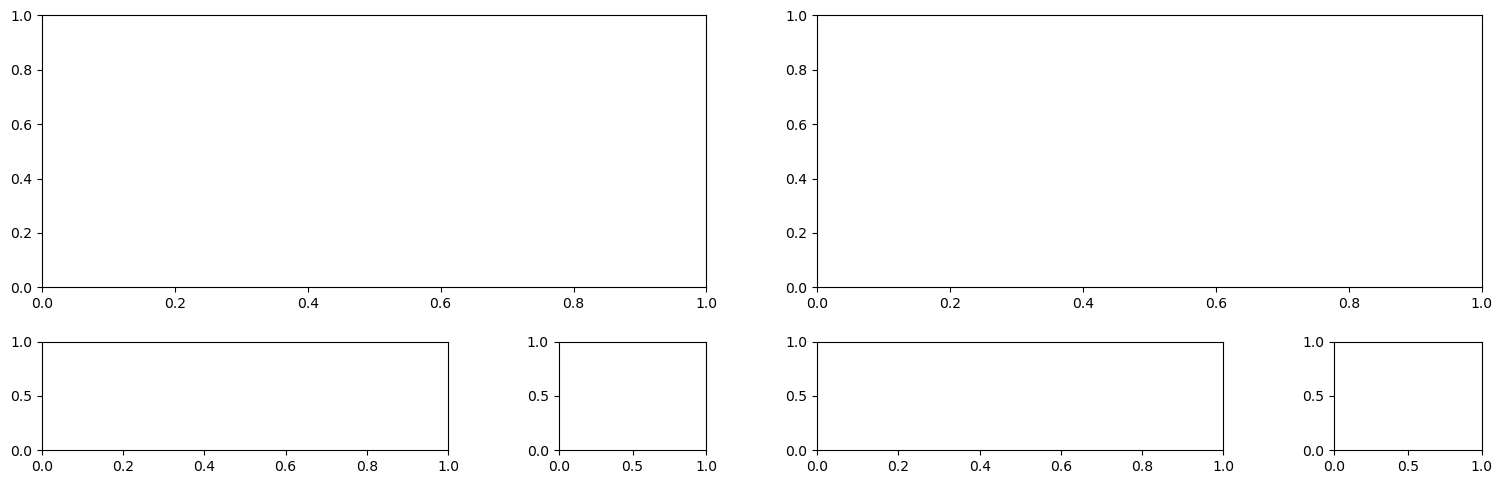

In [13]:
rows = 6
columns = 6
fig = plt.subplots(figsize=(16,12), dpi=100)
predictionA_timeseries = plt.subplot2grid((rows, columns), (0, 0), rowspan=2, colspan=3)
predictionB_timeseries = plt.subplot2grid((rows, columns), (0, 3), rowspan=2, colspan=3)
predictionA_dataseries = plt.subplot2grid((rows, columns), (2, 0), rowspan=1, colspan=2)
predictionB_dataseries = plt.subplot2grid((rows, columns), (2, 3), rowspan=1, colspan=2)
predictionA_table = plt.subplot2grid((rows, columns), (2, 2))
predictionB_table = plt.subplot2grid((rows, columns), (2, 5))
plt.subplots_adjust(left=0, wspace=0.75, hspace=0.50)


In [ ]:

    ''' PLOT TIME :) '''
    print('Plotting for ',gname,'...')
    
    fig = plt.subplots(figsize=(10,8), dpi=100)

    ''' DEC vs. Calibrated time series plot (top) '''
    time_series = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=3)
    time_series.set_title('time_series')
    time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    time_series.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.55)
    time_series.plot(testing_period,calibrated_data,label='Linear calibrated', color='red',linewidth=0.45)
    time_series.legend()  
    time_series.set_title('Two function TEST -- '+gname+' Regression Calibration Results | Training Period = Aug 2021, Testing Period = July, Sept-Nov 2021', fontsize=10)
    time_series.set_xlabel('Date')
    time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')

    ''' DEC vs. Calibrated trend  plot (bottom left) '''
    data_series = plt.subplot2grid((3, 3), (2, 0), colspan=2)
    data_series.set_title('data_series')
    data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    # 1:1 line
    if var_id==42101: # CO
        xmax = 2000
    if var_id==44201: # O3
        xmax = 200
    if var_id==42601: # NO
        xmax = 200
    if var_id==42602: # N02
        xmax = 70
    if var_id==88101: # pm25
        xmax = 80 
    ymax=xmax
    point1 = [0,0]
    point2 = [xmax,ymax]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    data_series.plot(x_values, y_values, color='black', label='1:1 Line')
    # plotting data... 
    data_series.scatter(testing_reference_concentrations,calibrated_data,color='red',s=0.25)
    data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
    data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)

    ''' Regression Coefficient Table (bottom right) '''
    # create dataframe of table data 
    table_data = pd.DataFrame()
    table_data = table_data.append(model[0],ignore_index=True)
    table_data = table_data.transpose()
    table_data = table_data.rename(columns = {0:'Coefficient'}, index={"00": "T", '01':'T²', '02':'RH','03':'T*RH','04':'T*VoltDiff',
                    '05':'VoltDiff','06':'Weekday Binary','intercept':'Y-Intercept'})
    table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
    table_data = table_data.round(3) # rounding coefficients to 3 decimal places 
    
    # creating table... 
    table = plt.subplot2grid((3, 3), (2, 2))
    table.text(-0.0912,0.067,'Regression Coefficients Table')
    # hide the axes
    table.patch.set_visible(False)
    table.axis('off')
    table.axis('tight')
    regression_table = table.table(cellText=table_data.values, rowLabels=table_data.index, loc='center')
    regression_table.scale(0.5,1.5)
    regression_table.set_fontsize(10)

    # adjust layout to make room for the table (do not adjust without testing first)
    plt.subplots_adjust(left=0, wspace=0.75, hspace=0.50)

    ''' Display model performance statistics (text) '''
    table.text(1.028,-0.01, 'Linear... r²= '+str(round(model_perf['r2'],2))+' |  m= '+str(round(model_perf['m'],2))+' |  RMSE = '+str(round(model_perf['RMSE'],0)), 
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red', fontsize=8)
    
   # time_series.text(0.25, 0.8, 'Predictors used = '+predictor_text, horizontalalignment='center',
                 #verticalalignment='center', transform=time_series.transAxes, color='red', fontsize=8) 
   # THIS NEEDS TO BE REWORKED IF WE WANT TO INCLUDE PREDICTORS = TEXT... 
    
    #plt.savefig("/data/shared/ehojeily/calibrate-function-testing/predict_2x_draftPlots_wRegCoeffTable/"+gname +'_AugCalibration_plt.png', dpi=600)
    plt.show()
    print('\n')


In [ ]:
    ''' A - Regression Coefficient Table (left bottom right) '''
    # create dataframe of table data 
    table_data = pd.DataFrame()
    table_data = table_data.append(model[0],ignore_index=True)
    table_data = table_data.transpose()
    table_data = table_data.rename(columns = {0:'Coefficient'}, index={"00": "T", '01':'T²', '02':'RH','03':'T*RH','04':'T*VoltDiff',
                    '05':'VoltDiff','06':'Weekday Binary','intercept':'Y-Intercept'})
    table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
    table_data = table_data.round(3) # rounding coefficients to 3 decimal places 
    
    # creating table... 
    predictionA_table = plt.subplot2grid((rows, columns), (2, 2))
    predictionA_table.text(-0.0912,0.067,'Regression Coefficients Table')
    # hide the axes
    predictionA_table.patch.set_visible(False)
    predictionA_table.axis('off')
    predictionA_table.axis('tight')
    regression_table_A = predictionA_table.table(cellText=table_data.values, rowLabels=table_data.index, loc='center')
    regression_table_A.scale(0.5,1.5)
    regression_table_A.set_fontsize(10)